(https://keras.io/examples/nlp/text_extraction_with_bert/) 

In [1]:
import matplotlib.pyplot as plt
import os
import re
import string
import numpy as np
import pandas as pd
import tensorflow as tf
import transformers
from tensorflow import keras
from tensorflow.keras import layers
from transformers import BertTokenizer, TFBertModel, BertConfig, BertTokenizerFast 
print(tf.__version__)

from learning_checks import hist_graph
from learning_checks import text_check
from learning_checks import check_metrics

2.4.1


In [2]:
labels = [
"Reductio ad hitlerum",
"Whataboutism",
"Presenting Irrelevant Data (Red Herring)",
"Doubt",
"Slogans",
"Appeal to fear/prejudice",
"Obfuscation, Intentional vagueness, Confusion",
"Misrepresentation of Someone's Position (Straw Man)",
"Glittering generalities (Virtue)",
"Appeal to authority",
"Repetition",
"Bandwagon",
"Causal Oversimplification",
"Name calling/Labeling",
"Thought-terminating cliché",
"Flag-waving",
"Exaggeration/Minimisation",
"Smears",
"Loaded Language",
"Black-and-white Fallacy/Dictatorship"
]

In [3]:
data_pd = pd.read_csv("data.csv").sample(20)
data_pd = data_pd.reset_index().drop(columns=["index"])

In [4]:
data_pd

,text,prop_mask,technique
0,Which leads me then to wonder: If they're real...,[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0...,Doubt
1,"Putting aside freedom of speech, the persecuti...",[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0...,Loaded Language
2,No fact-checking,[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1],Doubt
3,THAT'S A FACT \n\nDID YOU KNOW THE NRA TRAINED...,[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0...,Smears
4,It may even prove a political masterstroke of ...,[0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1...,Loaded Language
5,"This was, remember, 1965, four years before th...",[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0...,Loaded Language
6,But to see the partisans of the defeated candi...,[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1...,Doubt
7,"LIBERAL LOGIC: ""DON'T CALL THEM ANIMALS!""\n\n""...",[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0...,Thought-terminating cliché
8,Orban is openly Christian and seems to underst...,[0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1...,Flag-waving
9,"The handover was done with much fanfare, then ...",[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0...,Loaded Language


In [5]:
def make_list(x):
    x = x[1:-1].split()
    x = list(map(int, x))
    return x

data_pd["prop_mask"] = data_pd["prop_mask"].apply(lambda x: make_list(x))

In [6]:
from transformers import AutoTokenizer, AutoModel

tokenizer = AutoTokenizer.from_pretrained("SpanBERT/spanbert-base-cased")

In [7]:
def preprocessing(data, max_len=250):
    col_input_ids = []
    col_attention_mask = []
    col_token_type_ids = []
    col_token_prop_mask = []
    
    for i in range(data.shape[0]):
        token_text = tokenizer.encode_plus(
            data["text"][i], 
            return_offsets_mapping=True,
            max_length=max_len,
            truncation=True
        )
        
        token_count = len(token_text.input_ids)
        token_prop_mask = [0] * max_len
        for j, (ind_s, ind_e) in enumerate(token_text.offset_mapping):
            if sum(data["prop_mask"][i][ind_s:ind_e]) > 0:
                #print(data["text"][i][ind_s:ind_e], 109)
                token_prop_mask[j] = 1
            
        col_token_prop_mask.append(token_prop_mask) 

        token_technique = tokenizer.encode_plus(
            data["technique"][i], 
            return_offsets_mapping=True, 
            max_length=max_len, 
            truncation=True
        )

        input_ids = token_text.input_ids + token_technique.input_ids[1:]
        token_type_ids = [0] * token_count + [1] * len(token_technique.input_ids[1:])
        len_input_ids = len(input_ids)
        attention_mask = [1] * len_input_ids

        assert max_len > len_input_ids, f"max_len {max_len} <= len_input_ids {len_input_ids}"
        
        padding = [0] * (max_len - len_input_ids)
        col_input_ids.append(input_ids + padding)
        col_attention_mask.append(attention_mask + padding)
        col_token_type_ids.append(token_type_ids + padding)

        #if sum(token_prop_mask) > 0:
        #    print(data["technique"][i])
        #    print(data["text"][i])
        #    inp_ids = np.array(input_ids + padding)
        #    mask_ids = np.array(token_prop_mask)
        #    np_text = np.array(list(data["text"][i]))
        #    np_prop = np.array(data["prop_mask"][i])
        #    my_tok = inp_ids[mask_ids == 1] 
        #    prop_mask = data["prop_mask"][i]
        #    print("|", "".join(np_text[np_prop == 1]), "|")
        #    print(tokenizer.decode(my_tok))
        #    return
        
    return col_input_ids, col_attention_mask, col_token_type_ids, col_token_prop_mask

In [8]:
col_input_ids, col_attention_mask, col_token_type_ids, col_token_prop_mask = preprocessing(data_pd)
data_pd["col_input_ids"] = col_input_ids
data_pd["col_attention_mask"] = col_attention_mask
data_pd["col_token_type_ids"] = col_token_type_ids
data_pd["col_token_prop_mask"] = col_token_prop_mask

In [9]:
data_pd

,text,prop_mask,technique,col_input_ids,col_attention_mask,col_token_type_ids,col_token_prop_mask
0,Which leads me then to wonder: If they're real...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",Doubt,"[101, 1134, 4501, 1143, 1173, 1106, 4608, 131,...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, ..."
1,"Putting aside freedom of speech, the persecuti...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",Loaded Language,"[101, 4518, 4783, 4438, 1104, 4055, 117, 1103,...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
2,No fact-checking,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]",Doubt,"[101, 1185, 1864, 118, 9444, 102, 4095, 102, 0...","[1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, ...","[0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
3,THAT'S A FACT \n\nDID YOU KNOW THE NRA TRAINED...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",Smears,"[101, 1115, 112, 188, 170, 1864, 1225, 1128, 1...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
4,It may even prove a political masterstroke of ...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, ...",Loaded Language,"[101, 1122, 1336, 1256, 5424, 170, 1741, 11573...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, ..."
5,"This was, remember, 1965, four years before th...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",Loaded Language,"[101, 1142, 1108, 117, 2676, 117, 2679, 117, 1...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
6,But to see the partisans of the defeated candi...,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",Doubt,"[101, 1133, 1106, 1267, 1103, 17696, 1116, 110...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."
7,"LIBERAL LOGIC: ""DON'T CALL THEM ANIMALS!""\n\n""...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",Thought-terminating cliché,"[101, 7691, 8738, 131, 107, 1274, 112, 189, 18...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, ..."
8,Orban is openly Christian and seems to underst...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, ...",Flag-waving,"[101, 1137, 7167, 1110, 9990, 22572, 12937, 18...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, ..."
9,"The handover was done with much fanfare, then ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",Loaded Language,"[101, 1103, 1289, 5909, 1108, 1694, 1114, 1277...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, ..."


In [10]:
FRACTION = 0.1
data_num = int(data_pd.shape[0] * FRACTION)

data_pd = data_pd.sample(frac=1).reset_index(drop=True)
sep_dev_pd = data_pd.iloc[:data_num,:]
sep_train_pd = data_pd.iloc[data_num:,:].reset_index(drop=True)

In [11]:
sep_dev_pd

,text,prop_mask,technique,col_input_ids,col_attention_mask,col_token_type_ids,col_token_prop_mask
0,If we wipe out the Coronavirus when the warm w...,"[0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, ...",Loaded Language,"[101, 1191, 1195, 14182, 1149, 1103, 1884, 157...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
1,"The people who talk about the ""Jewish question...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",Causal Oversimplification,"[101, 1103, 1234, 1150, 2037, 1164, 1103, 107,...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."


In [12]:
import torch.nn as nn

class Model(transformers.BertPreTrainedModel):
    def __init__(self, config, PATH):
        super(Model, self).__init__(config)
        self.bert = transformers.BertModel.from_pretrained(PATH)
        self.linear = nn.Linear(1024, 1)
        self.flatten = nn.Flatten()
        self.sigm = nn.Sigmoid()
    
    def forward(self, ids, mask, token_type_ids):
        embedding = self.bert(
            ids,
            attention_mask=mask,
            token_type_ids=token_type_ids
        )[0]
        logits = self.linear(embedding)
        logits = self.flatten(logits)
        result = self.sigm(logits)
        return result

In [13]:
PATH = 'tune_model/squad2'

bert = transformers.BertModel.from_pretrained(PATH)
my_model = Model(bert.config, PATH)

In [14]:
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

optimizer = optim.SGD(my_model.parameters(), lr=1e-2)
criterion = nn.BCELoss()

In [15]:
import torch

if torch.cuda.is_available():  
  dev = "cuda:0" 
else:  
  dev = "cpu" 

dev

'cpu'

In [16]:
my_model.to(dev)
print(1)

1


In [17]:
sep_dev_pd

,text,prop_mask,technique,col_input_ids,col_attention_mask,col_token_type_ids,col_token_prop_mask
0,If we wipe out the Coronavirus when the warm w...,"[0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, ...",Loaded Language,"[101, 1191, 1195, 14182, 1149, 1103, 1884, 157...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
1,"The people who talk about the ""Jewish question...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",Causal Oversimplification,"[101, 1103, 1234, 1150, 2037, 1164, 1103, 107,...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."


technique: Loaded Language
---
text: If we wipe out the Coronavirus when the warm weather comes we can tell the liberals that Global Warming killed it and watch their heads explode!

---
ans: [CLS]
---
true ans: wipe out global warming killed heads explode!
---


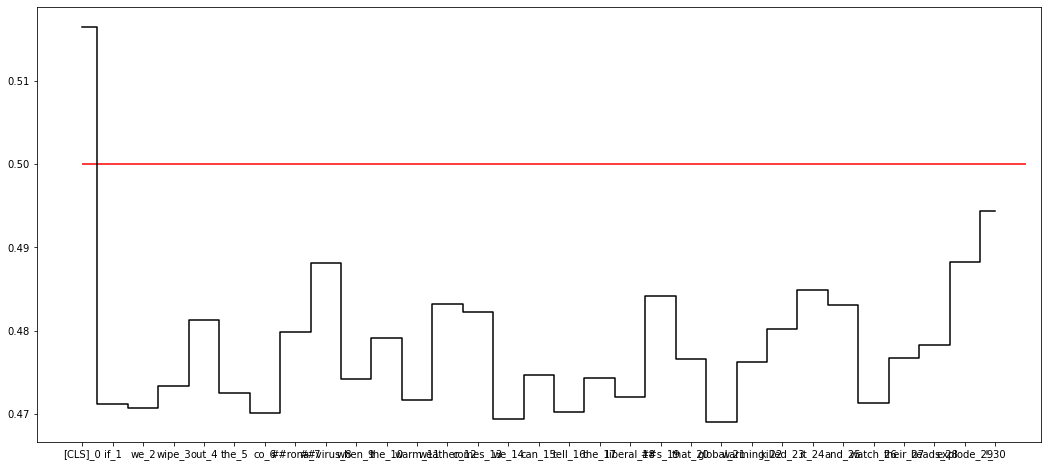

In [18]:
i = 0
text_check(my_model, i, 0.5, sep_dev_pd, tokenizer)

In [19]:
from tqdm.notebook import trange, tqdm

EPOCHS = 4
batch_size = 5
dev_batch_size = 10
N = len(sep_train_pd)
M = len(sep_dev_pd)
data = sep_train_pd.values

precision = []
recall = []
accuracy = []
F = []

for epoch in range(EPOCHS):
    
    my_model.train()
    train_loss = 0
    for i in tqdm(range(0, N, batch_size), leave=False):
        start = i
        end = i + batch_size if i + batch_size < N else N
        ids = torch.tensor(list(sep_train_pd["col_input_ids"][start:end])).to(dev)
        attention_mask = torch.tensor(list(sep_train_pd["col_attention_mask"][start:end])).to(dev)
        type_ids = torch.tensor(list(sep_train_pd["col_token_type_ids"][start:end])).to(dev)
        target = torch.tensor(list(sep_train_pd["col_token_prop_mask"][start:end]), dtype=torch.float).to(dev)
        
        optimizer.zero_grad()
        output = my_model(ids, attention_mask, type_ids)
        output = torch.squeeze(output, dim=1)
        loss = criterion(output, target * 0.99)
        train_loss += loss
        loss.backward()
        optimizer.step()
        
    dev_loss = 0
    my_model.eval()
    with torch.no_grad():
        for i in range(0, M, dev_batch_size):
            start = i
            end = i + dev_batch_size if i + dev_batch_size < M else M
            ids = torch.tensor(list(sep_dev_pd["col_input_ids"][start:end])).to(dev)
            attention_mask = torch.tensor(list(sep_dev_pd["col_attention_mask"][start:end])).to(dev)
            type_ids = torch.tensor(list(sep_dev_pd["col_token_type_ids"][start:end])).to(dev)
            target = torch.tensor(list(sep_dev_pd["col_token_prop_mask"][start:end]), dtype=torch.float).to(dev)
            
            output = my_model(ids, attention_mask, type_ids)
            output = torch.squeeze(output, dim=1)
            loss = criterion(output, target * 0.99)
            dev_loss += loss
        print(f"\nepoch {epoch}: \ntrain_loss = {train_loss}, \ndev_loss = {dev_loss}")
    check_metrics(my_model, sep_dev_pd, 0.5)


epoch 0: 
train_loss = 2.226478338241577, 
dev_loss = 0.4069599509239197


NameError: name 'my_model' is not defined

In [ ]:
check_metrics(my_model, sep_dev_pd)

In [ ]:
torch.save(my_model.state_dict(), "models/model.pth")